In [7]:
import torch
import time

torch._dynamo.config.cache_size_limit = 64  # type:ignore
values = []


def calc_flops(func, sz, loop_iters):
    inputs = [torch.randn(sz, device='cuda', dtype=torch.float32)]

    print(inputs[0].dtype)
    for _ in range(5):
        func(*inputs)
    torch.cuda.synchronize()
    iters = 100
    begin = time.time()
    for _ in range(iters):
        func(*inputs)
    torch.cuda.synchronize()
    t = (time.time()-begin)
    iters_per_s = iters/t
    flops = 2 * sz * loop_iters
    bytes_per_elem = 4
    num_reads = 1
    num_writes = 1
    mem_bw = sz * (num_reads + num_writes) * bytes_per_elem
    print(f"{loop_iters} ops")
    print(f"itr time: {t *1e6 / iters}")
    print(f"FLOPS: {iters_per_s * flops/1e12:.2f} TF/s")
    print(f"Mem B/W: {iters_per_s * mem_bw/1e9:.2f} GB/s")
    print()
    values.append((t / iters, iters_per_s * flops, iters_per_s * mem_bw))


for iters in [2**i for i in range(10)]:
    @torch.compile
    def f(x):
        for _ in range(iters):
            x = x * 2 + x
        return x

    sz = 2**30
    # f = torch.jit.trace(f, (torch.randn(sz, device='cuda')))
    # with torch.jit.fuser("fuser2"):
    calc_flops(f, sz, iters)
    # print(values)

torch.float32
1 ops
itr time: 4875.7123947143555
FLOPS: 0.44 TF/s
Mem B/W: 1761.78 GB/s

torch.float32
2 ops
itr time: 4875.218868255615
FLOPS: 0.88 TF/s
Mem B/W: 1761.96 GB/s

torch.float32
4 ops
itr time: 4875.929355621338
FLOPS: 1.76 TF/s
Mem B/W: 1761.70 GB/s

torch.float32
8 ops
itr time: 4883.325099945068
FLOPS: 3.52 TF/s
Mem B/W: 1759.03 GB/s

torch.float32
16 ops
itr time: 4925.863742828369
FLOPS: 6.98 TF/s
Mem B/W: 1743.84 GB/s

torch.float32
32 ops
itr time: 4987.373352050781
FLOPS: 13.78 TF/s
Mem B/W: 1722.34 GB/s

torch.float32
64 ops
itr time: 7550.8832931518555
FLOPS: 18.20 TF/s
Mem B/W: 1137.61 GB/s

torch.float32
128 ops
itr time: 14537.711143493652
FLOPS: 18.91 TF/s
Mem B/W: 590.87 GB/s

torch.float32
256 ops
itr time: 28778.328895568848
FLOPS: 19.10 TF/s
Mem B/W: 298.49 GB/s

torch.float32
512 ops
itr time: 58229.12693023682
FLOPS: 18.88 TF/s
Mem B/W: 147.52 GB/s



In [9]:
times, flops, mem_bw = zip(*values)

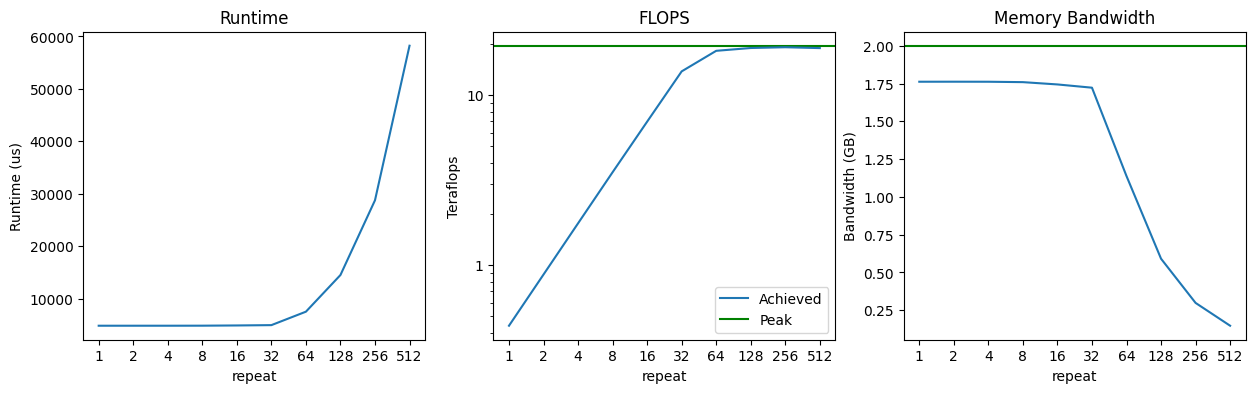

In [10]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

peak_tflops = 19.5  # 8.141/2
peak_bw = 2

gs = gridspec.GridSpec(1, 3)
plt.figure(figsize=(15,4))

plt.subplot(gs[0])
# plt.yscale('log')
plt.xlabel('repeat')
plt.ylabel('Runtime (us)')
plt.plot([str(2**i) for i in range(len(times))], [i * 1e6 for i in times])
plt.title("Runtime")
# plt.show()

plt.subplot(gs[1])

peak = plt.axhline(peak_tflops, color = 'g')
# plt.xscale('log')
plt.yscale('log')
plt.xlabel('repeat')
plt.ylabel('Teraflops')
res, = plt.plot([str(2**i) for i in range(len(flops))], [i/1e12 for i in flops])
ax = plt.gca()
import matplotlib.ticker as mticker
plt.legend([res, peak], ['Achieved', 'Peak'])

plt.title("FLOPS")
ax.yaxis.set_major_formatter(mticker.ScalarFormatter())


plt.subplot(gs[2])
peak = plt.axhline(peak_bw, color = 'g')

# plt.yscale('log')
plt.xlabel('repeat')
plt.ylabel('Bandwidth (GB)')
plt.plot([str(2**i) for i in range(len(mem_bw))], [i/1e12 for i in mem_bw])
ax = plt.gca()
ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
ax.yaxis.set_minor_formatter(mticker.ScalarFormatter())

import matplotlib.ticker as mticker

plt.title("Memory Bandwidth")
plt.savefig('microbench.png', bbox_inches='tight')